<img src="../images/diamond.png" alt="Drawing" style="width: 150px;"/>

# **Diamond Datasheet** 
## **NotebookML 001**

***

## Creation of synthetic variables

***


In [19]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 0)

In [20]:
df=pd.read_csv(f'../data/raw/diamonds_train.csv')
dfpredict=pd.read_csv(f'../data/raw/diamonds_predict.csv')



***

### Concat the datasheet train and predict

***

In [21]:
df['df_original']=1
dfpredict['df_original']=0
print(df.shape)
print(dfpredict.shape)

df=pd.concat([df,dfpredict], axis=0)
df['df_original'].value_counts()


(40455, 11)
(13485, 11)


1    40455
0    13485
Name: df_original, dtype: int64

In [22]:
df['cut'] = df['cut'].astype('category')
df['color'] = df['color'].astype('category')
df['clarity'] = df['clarity'].astype('category')


***

### Create numeric categories

***

In [23]:
df['cut_int']=''

df.loc[df['cut']=='Fair','cut_int']=1
df.loc[df['cut']=='Good','cut_int']=2
df.loc[df['cut']=='Very Good','cut_int']=3
df.loc[df['cut']=='Premium','cut_int']=4
df.loc[df['cut']=='Ideal','cut_int']=5

df['cut_int'] = df['cut_int'].astype('int64')

df['color_int']=''

df.loc[df['color']=='J','color_int']=1
df.loc[df['color']=='I','color_int']=2
df.loc[df['color']=='H','color_int']=3
df.loc[df['color']=='G','color_int']=4
df.loc[df['color']=='F','color_int']=5
df.loc[df['color']=='E','color_int']=6
df.loc[df['color']=='D','color_int']=7


df['color_int'] = df['color_int'].astype('int64')

df['clarity_int']=''

df.loc[df['clarity']=='I1','clarity_int']=1
df.loc[df['clarity']=='SI2','clarity_int']=2
df.loc[df['clarity']=='SI1','clarity_int']=3
df.loc[df['clarity']=='VS2','clarity_int']=4
df.loc[df['clarity']=='VS1','clarity_int']=5
df.loc[df['clarity']=='VVS2','clarity_int']=6
df.loc[df['clarity']=='VVS1','clarity_int']=7
df.loc[df['clarity']=='IF','clarity_int']=8


df['clarity_int'] = df['clarity_int'].astype('int64')

***

### Create Score

***

Score is a sythetic variable made with this formula: 0.793645  *  cut_int + 10.217867 * color_int + 18.53525155 * clarity_int. The numbers are the importances of this features.


In [24]:
df['cut_color_clarity_score'] = df.apply(lambda new: 0.793645*new['cut_int']+10.217867*new['color_int']+18.53525155*new['clarity_int'], axis=1)

***

### Create raw density

***

Raw density is a sythetic variable made with this density of the diamonds.

In [25]:
df['raw_density'] = (df['carat']*0.2)/(df['x']*df['y']*df['z']/3/1000)
df['raw_density'] = np.where(df['raw_density']==float('Inf'),0,df['raw_density'])


***

### Create Marketing carat

***

Marketing Carat is a sythetic variable made for increase the price for the diamonds with special carat (1.00, 2.00) and also for decrease diamonds with special carat (0.99, 1.99)

In [26]:
def marketing_carat(x):
    h=0.02
    for z in range(1,3):
        if (z-h)<=x<(z):             #bad 0.91 a 0.99  good  1.00 a 1.04
            y='bad'
            break
        elif (z)<=x<=(z+h+0.02):
            y='good'
            break
        elif 1.48<=x<1.50:
            y='bad'
            break  
        elif 1.50<=x<=1.54:
            y='good'
            break     
            
        else:
            y='regular'
    return y

df['marketing_carat']=df.apply(lambda x: marketing_carat(x['carat']), axis=1) 
    
df['marketing_carat_int']=''

df.loc[df['marketing_carat']=='bad','marketing_carat_int']=1
df.loc[df['marketing_carat']=='regular','marketing_carat_int']=2
df.loc[df['marketing_carat']=='good','marketing_carat_int']=3



df['marketing_carat_int'] = df['marketing_carat_int'].astype('int64')    
df['marketing_carat'].value_counts()


regular    44714
good        9146
bad           80
Name: marketing_carat, dtype: int64

***

### Create Carat SQR

***

Carat Sqr is a sythetic variable made with the carat cubed.

In [27]:
df['carat_sqr']=df['carat']**3

# df['carat_sqr'] = np.where(df['carat_sqr']==float('Inf'),0,df['carat_sqr'])

***

### Create High

***

High is a sythetic variable made for increase the price prediction for the carats above 1.28 and 2.23.

In [28]:
df['high']=''

# high=2.23
# df.loc[df['carat']<high,'high']=1
# df.loc[df['carat']>=high,'high']=2



high=2.23
high2=1.28

df.loc[df['carat']<high2,'high']=1
df.loc[(df['carat']>=high2)&(df['carat']<high),'high']=2
df.loc[df['carat']>=high,'high']=3


df['high'] = df['high'].astype('int64')

df['high'].value_counts()

1    46540
2     6988
3      412
Name: high, dtype: int64

***

### Change the X Y Z variables.

***

I changed the values below 0.1 and above 25 for the mean of diamonds with same carats.

In [29]:


x_y_z_0=df.loc[(df['x']<0.01)|(df['y']<0.01) |(df['z']<0.01)|(df['x']>25)|(df['y']>25)|(df['z']>25)].sort_values(by=['id'], ascending=False).index.to_list()



def deletexyz(a,b,c):
    if b<0.01 or b>25:
        return df.loc[df['carat']==a,c].mean()
    else:
        return b
    
df['x'] = df.apply(lambda new: deletexyz(new['carat'],new['x'],'x'), axis=1)
df['y'] = df.apply(lambda new: deletexyz(new['carat'],new['y'],'y'), axis=1)
df['z'] = df.apply(lambda new: deletexyz(new['carat'],new['z'],'z'), axis=1)





***

### Create dummies datasheet.

***

Create datasheet with One hot encoder

In [30]:
dfd=pd.get_dummies(df)

In [31]:
df.to_parquet('../data/processed/df.parquet')
dfd.to_parquet('../data/processed/dfd.parquet')


***

### Visualize the correlations

***



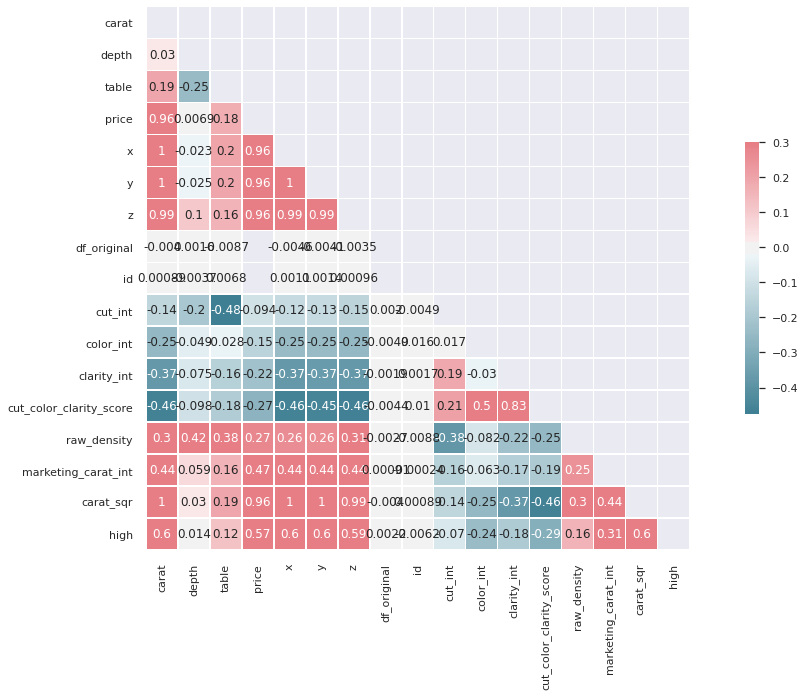

In [32]:

sns.set(font_scale=1)
dft=df.corr(method='spearman')
mask = np.triu(np.ones_like(dft, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(dft, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()


